In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mne
from mne.channels import find_ch_adjacency
from mne.datasets import sample
from mne.stats import combine_adjacency, spatio_temporal_cluster_test
from mne.time_frequency import tfr_morlet
from mne.viz import plot_compare_evokeds

In [2]:
data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"
event_fname = meg_path / "sample_audvis_filt-0-40_raw-eve.fif"
event_id = {"Aud/L": 1, "Aud/R": 2, "Vis/L": 3, "Vis/R": 4}
tmin = -0.2
tmax = 0.5

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.filter(1, 25)
events = mne.read_events(event_fname)

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 669GB/s]
Untarring contents of '/Users/qingchen/mne_data/MNE-sample-data-processed.tar.gz' to '/Users/qingchen/mne_data'


Attempting to create new mne-python configuration file:
/Users/qingchen/.mne/mne-python.json
Download complete in 04m04s (1576.2 MB)
Opening raw data file /Users/qingchen/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper tra

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    0.2s finished


In [3]:
picks = mne.pick_types(raw.info, meg="mag", eog=True)

reject = dict(mag=4e-12, eog=150e-6)
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    decim=2,  # just for speed!
    baseline=None,
    reject=reject,
    preload=True,
)

epochs.drop_channels(["EOG 061"])
epochs.equalize_event_counts(event_id)

# Obtain the data as a 3D matrix and transpose it such that
# the dimensions are as expected for the cluster permutation test:
# n_epochs × n_times × n_channels
X = [epochs[event_name].get_data(copy=False) for event_name in event_id]
X = [np.transpose(x, (0, 2, 1)) for x in X]

Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Using data from preloaded Raw for 288 events and 106 original time points (prior to decimation) ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch bas

Reading adjacency matrix for neuromag306mag.
<class 'scipy.sparse._csr.csr_matrix'>


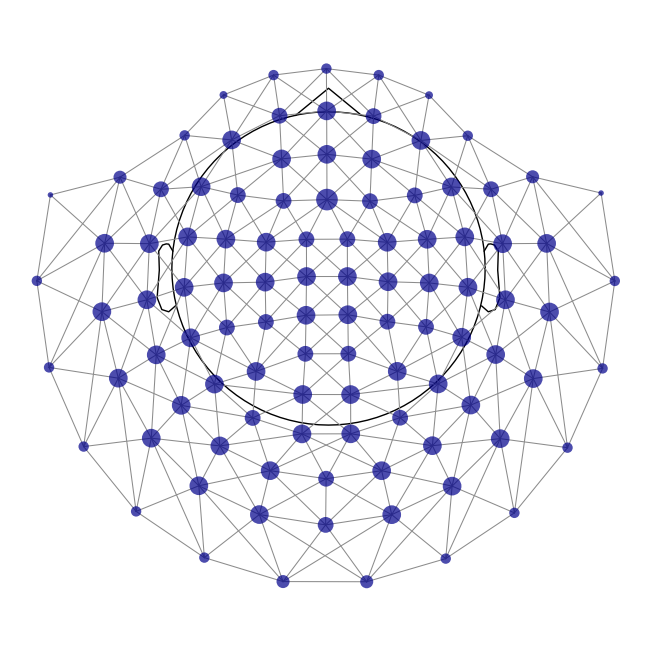

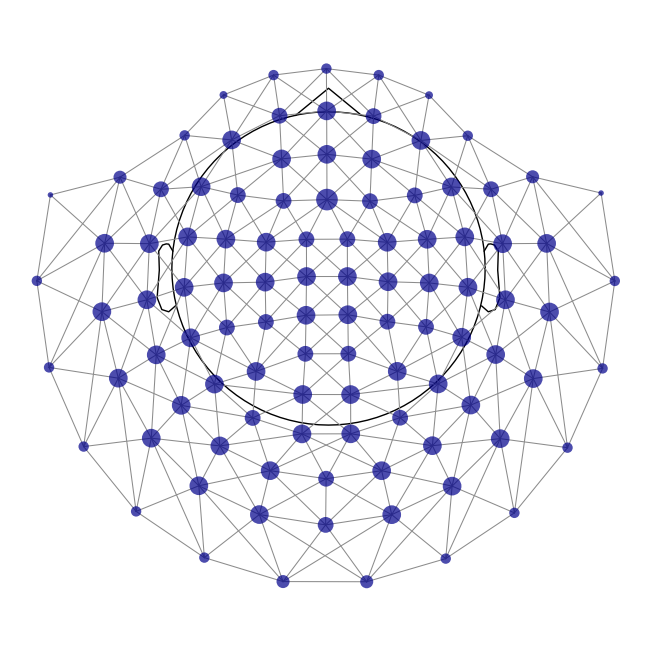

In [4]:
adjacency, ch_names = find_ch_adjacency(epochs.info, ch_type="mag")

print(type(adjacency))  # it's a sparse matrix!

mne.viz.plot_ch_adjacency(epochs.info, adjacency, ch_names)

In [9]:
print(X)
print(X[0].shape)

[array([[[-1.51394878e-13, -1.31440652e-13, -7.18125126e-14, ...,
         -1.33538868e-14, -3.28147979e-14, -1.56128139e-13],
        [-9.93327574e-15, -3.76439365e-14,  5.56306462e-14, ...,
          3.71598664e-14,  6.70766934e-14, -2.54650370e-14],
        [-2.31422563e-14, -5.87815856e-14,  6.64357036e-14, ...,
         -7.05786338e-14, -3.75060636e-14, -7.30602418e-15],
        ...,
        [-1.40286662e-13, -9.77624586e-14, -9.64455065e-14, ...,
         -1.86806552e-14,  1.60084832e-14, -1.50312389e-13],
        [-1.32115036e-13, -5.37086217e-14, -4.29710607e-14, ...,
         -6.90972698e-14, -3.71921756e-15, -1.31221587e-13],
        [ 8.68231616e-15,  4.38059544e-15, -2.35763243e-14, ...,
         -1.14820095e-13, -7.23711600e-14,  1.10315742e-13]],

       [[-1.46834990e-13, -4.53308124e-14, -1.46800420e-13, ...,
          3.99144476e-14,  3.63005974e-14, -6.61089187e-14],
        [-2.16548552e-13, -2.32232925e-13, -2.82084341e-13, ...,
         -1.05922679e-14, -4.31464266

In [8]:
# We are running an F test, so we look at the upper tail
# see also: https://stats.stackexchange.com/a/73993
tail = 1

# We want to set a critical test statistic (here: F), to determine when
# clusters are being formed. Using Scipy's percent point function of the F
# distribution, we can conveniently select a threshold that corresponds to
# some alpha level that we arbitrarily pick.
alpha_cluster_forming = 0.001

# For an F test we need the degrees of freedom for the numerator
# (number of conditions - 1) and the denominator (number of observations
# - number of conditions):
n_conditions = len(event_id)
n_observations = len(X[0])
dfn = n_conditions - 1
dfd = n_observations - n_conditions

# Note: we calculate 1 - alpha_cluster_forming to get the critical value
# on the right tail
f_thresh = scipy.stats.f.ppf(1 - alpha_cluster_forming, dfn=dfn, dfd=dfd)
print('--->',f_thresh)
# run the cluster based permutation analysis
cluster_stats = spatio_temporal_cluster_test(
    X,
    n_permutations=1000,
    threshold=f_thresh,
    tail=tail,
    n_jobs=None,
    buffer_size=None,
    adjacency=adjacency,
)
F_obs, clusters, p_values, _ = cluster_stats

---> 6.297776530471571
stat_fun(H1): min=0.003379 max=207.775354
Running initial clustering …
Found 22 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [ ]:
print()